In [12]:
# Install the required packages
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
# typing imports and aliases

from typing import TypeAlias
from typing import Optional, Any
Number: TypeAlias = int | float

In [14]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as Axes
import seaborn as sns

In [15]:
# add utility functions from cohort and homework exercises

def normalize_z(array: np.ndarray, 
                columns_means: Optional[np.ndarray]=None, 
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Normalize the input array using the Z-score normalization method.
    """
    if columns_means is None:
            columns_means = array.mean(axis=0)
    if columns_stds is None:
            columns_stds = array.std(axis=0)
    columns_means = np.array(columns_means)  # Convert to NumPy array
    columns_stds = np.array(columns_stds)    # Convert to NumPy array
    out = (array - columns_means) / columns_stds
    out = np.array(out)    # Convert to NumPy array
    return out, columns_means, columns_stds


def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Extract the features and targets from the input DataFrame.
    """
    df_feature = df.loc[:, feature_names]
    df_target = df.loc[:, target_names]
    return df_feature, df_target

def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    """
    Add a column of ones to the input array, representing beta_0.
    """
    return np.concatenate((np.ones((np_feature.shape[0], 1)), np_feature), axis=1)

def predict_linreg(array_feature: np.ndarray, beta: np.ndarray, 
                   means: Optional[np.ndarray]=None, 
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Predict the target values using the linear regression model.
    """
    n,_,_ = normalize_z(array_feature, means, stds)
    X = prepare_feature(n)
    return calc_linreg(X, beta)

def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Calculate the linear regression model using the input feature matrix and beta values.
    """
    return np.matmul(X, beta)

def split_data(df_feature: pd.DataFrame, 
               df_target: pd.DataFrame, 
               random_state: Optional[int]=None, 
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the input features and targets into training and testing sets.
    """
    row = len(df_feature)
    test = int(row*test_size)
    np.random.seed(random_state)
    test_index = np.random.choice(row, test, replace=False)
    
    df_feature_test = df_feature.iloc[test_index].reset_index(drop=True)
    df_target_test = df_target.iloc[test_index].reset_index(drop=True)
    
    df_feature_train = df_feature.drop(test_index,axis = 'index').reset_index(drop=True)
    df_target_train = df_target.drop(test_index,axis = 'index').reset_index(drop=True)
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    """
    Calculate the R-squared score of the model.
    """
    row = y.shape[0]
    mean = np.sum(y)/row
    tot = np.sum((y-mean)**2)
    res = np.sum((y-ypred)**2)
    return (1 - res/tot)

def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    """
    Calculate the mean squared error of the model.
    """
    row = target.shape[0]
    return np.sum((target-pred)**2)/row

def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Compute the cost of the linear regression model.
    """
    e = calc_linreg(X, beta) - y
    m = e.shape[0]
    J = (1/(2*m)) * np.matmul(np.transpose(e), e)
    return np.squeeze(J)

def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray, 
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform gradient descent to find the optimal beta values.
    """
    J_storage = []
    for i in range(num_iters):
        m = X.shape[0]
        J_storage.append(compute_cost_linreg(X, y, beta))
        y_hat = calc_linreg(X, beta)
        beta = beta - np.matmul((alpha * (1/m)) * np.transpose(X), (y_hat-y))
    return beta, np.array(J_storage)

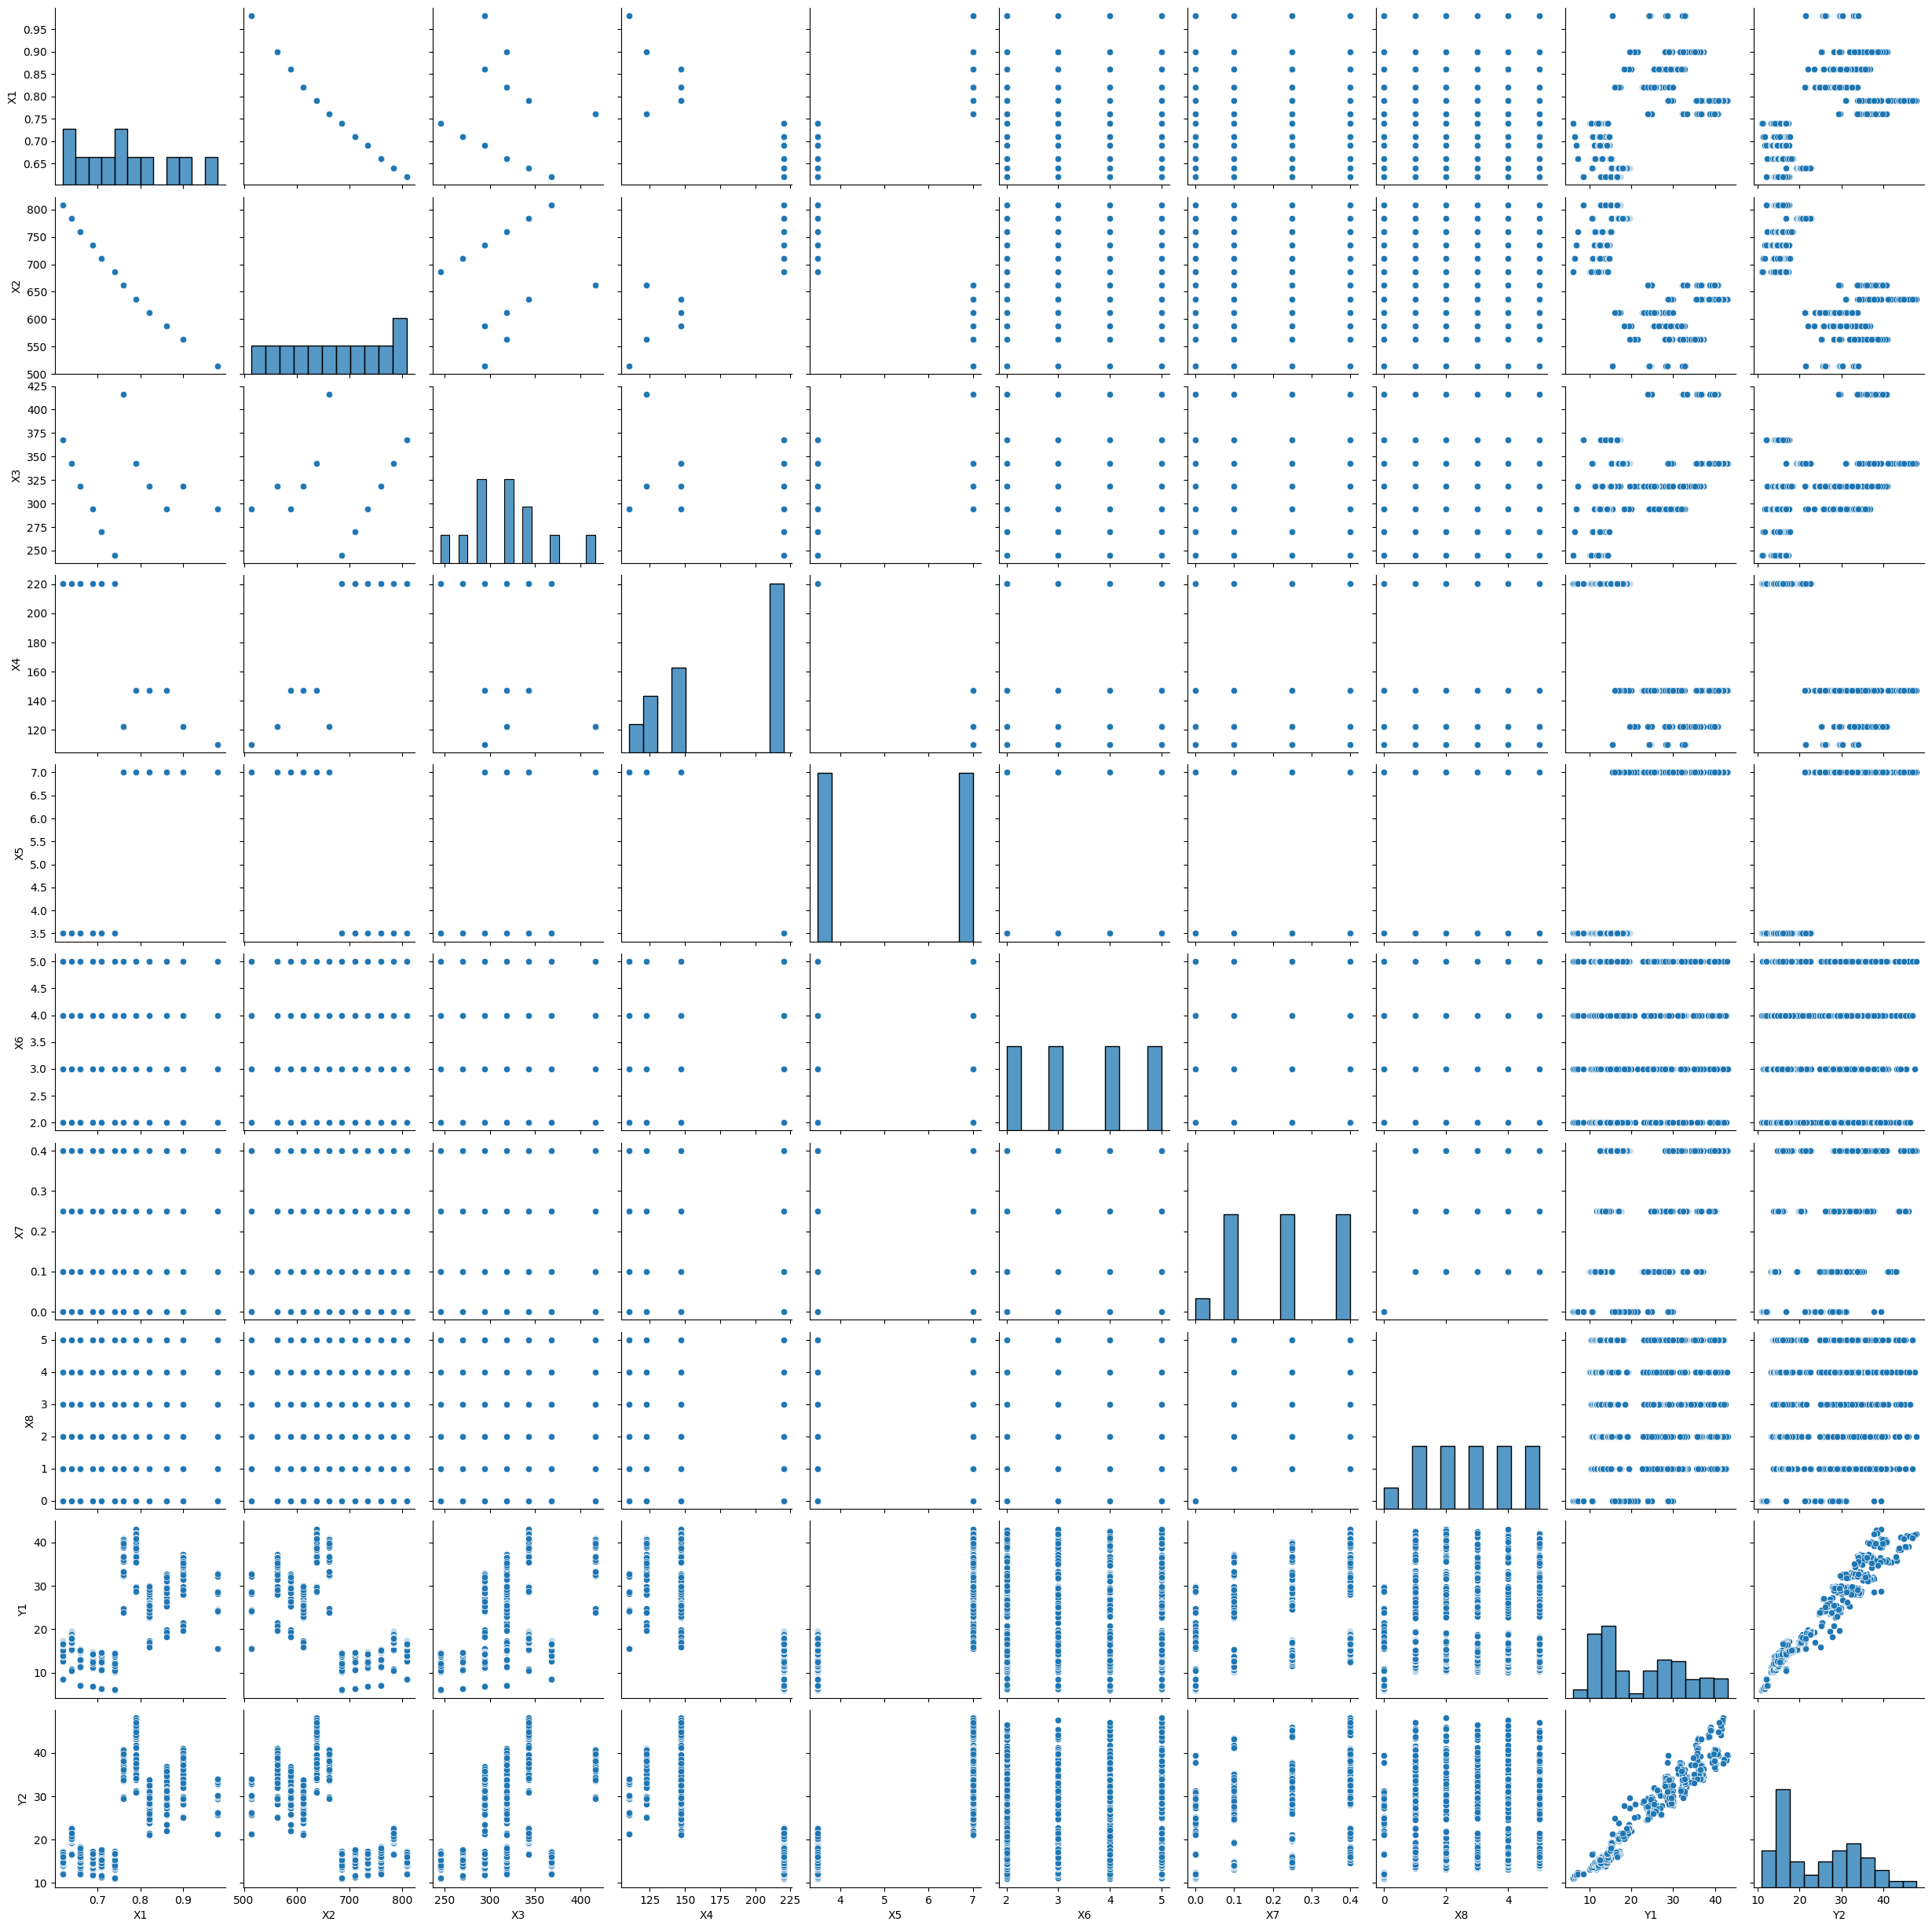

In [16]:
# dataset source: https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
# import the dataset from csv file
df = pd.read_csv('./data/ENB2012_data.csv')

# According to the dataset description, the columns are:
# X1. Relative Compactness
# X2. Surface Area
# X3. Wall Area
# X4. Roof Area
# X5. Overall Height
# X6. Orientation
# X7. Glazing Area
# X8. Glazing Area Distribution
# Y1. Heating Load
# Y2. Cooling

# preview the dataset
df.head()

sns.pairplot(df)

In [23]:
# extract the features and the target
# we only choose the continuous features and the target Y2
df_features, df_target = get_features_targets(df, ['X2', 'X3', 'X5', 'X7'], ['Y1', 'Y2'])

# split the dataset into training and testing sets
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.05)

# normalize the features
np_features_train, means, stds = normalize_z(df_features_train.to_numpy())

# prepare the features
X = prepare_feature(np_features_train)
target = df_target_train.to_numpy()

iterations = 10000
alpha = 0.01
beta = np.zeros((X.shape[1], 1))

beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

display(beta)

array([[22.30549315, 24.59287671],
       [ 1.00557421,  1.79695227],
       [ 1.79127961,  0.97863722],
       [ 9.31538728,  9.78039229],
       [ 2.69774665,  1.96382971]])

In [24]:
# predict using the beta values
pred = predict_linreg(df_features_test.to_numpy(), beta, means, stds)
display(pred)

array([[ 8.67295049, 12.50380022],
       [28.20803767, 31.17816032],
       [28.20803767, 31.17816032],
       [35.58286571, 36.65811613],
       [13.81968113, 16.69611626],
       [16.04777853, 17.98375603],
       [28.20803767, 31.17816032],
       [32.53879302, 34.44217773],
       [35.8424901 , 36.59222059],
       [13.47441321, 15.887598  ],
       [34.29618305, 35.61003711],
       [ 8.67295049, 12.50380022],
       [16.04777853, 17.98375603],
       [17.33446119, 19.03183504],
       [10.50361668, 14.17074499],
       [35.8424901 , 36.59222059],
       [28.20803767, 31.17816032],
       [27.46533853, 30.74894706],
       [32.7984174 , 34.37628219],
       [14.76109587, 16.93567702],
       [ 7.38626783, 11.45572121],
       [26.08682865, 28.63879005],
       [30.69575946, 32.39990455],
       [35.58286571, 36.65811613],
       [32.53879302, 34.44217773],
       [ 7.38626783, 11.45572121],
       [30.69575946, 32.39990455],
       [17.33446119, 19.03183504],
       [ 8.67295049,

In [25]:
# we can evaluate the model using the r2_score and mean_squared_error

r2 = r2_score(df_target_test.to_numpy(), pred)
mse = mean_squared_error(df_target_test.to_numpy(), pred)

display(r2, mse)

np.float64(0.9846616804445433)

np.float64(19.87804817069992)